In [1]:
# import libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as utils

import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [12]:
model_root_dir = '/notebooks/my-notebooks/MNIST/'

# get data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(model_root_dir+'MNIST_data', one_hot=False)

Extracting /notebooks/my-notebooks/MNIST/MNIST_data/train-images-idx3-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Hyperparams
input_size = 28
num_classes = 10

batch_size = 100
learning_rate = 0.2
dropout_rate = 0.4

epochs = 2

In [4]:
# create pytorch dataset with mnist data
training_dataset = utils.TensorDataset(torch.Tensor(mnist.train.images),torch.LongTensor(mnist.train.labels))

# create pytorch dataloader for extra features and ease of use in training loop
training_loader = utils.DataLoader(dataset=training_dataset,
                                   batch_size=batch_size,
                                   shuffle=True)

In [5]:
# define NN
class Net(nn.Module):
    
    def __init__(self, num_classes):
        super(Net, self).__init__()
        
        # define convolutional layers 1 and 2
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=5)
        
        # define fc layers 1 and 2, with 2 being the output layer
        self.fc1 = nn.Linear(16*4*4, 256)
        self.fc2 = nn.Linear(256, num_classes)
    
    # define forward pass
    def forward(self, x):
        
        x = x.view(-1,1,input_size,input_size)
        
        # apply conv1 and relu
        x = F.relu(self.conv1(x))
        # apply max pooling
        x = F.max_pool2d(input=x,kernel_size=(2,2),stride=2)
        
        # apply conv2 and relu
        x = F.relu(self.conv2(x))
        # apply max pooling
        x = F.max_pool2d(input=x,kernel_size=(2,2),stride=2)
        
        # flatten
        x = x.view(-1,16*4*4)
        
        # fc layer 1
        x = F.relu(self.fc1(x))
        # apply dropout to fc1
        x = F.dropout(input=x,p=dropout_rate,training=self.training)
        
        # output layer, with a fc
        out = self.fc2(x)
        
        return out

In [6]:
# set net to our Net with params
net = Net(num_classes)

# define loss function
loss_func = nn.CrossEntropyLoss() 
# define optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)  

In [7]:
# create function to calculate accuracy
def get_accuracy(images,labels):
    
    test_x = Variable(torch.Tensor(images))
    test_y = torch.LongTensor(labels)

    _outputs = net(test_x)
    _, _predicted = torch.max(_outputs.data, 1)
    
    num_correct = (_predicted.cpu() == test_y).sum()
    num_total = test_y.size(0)

    return(str(100.0 * num_correct/num_total)+'%')

In [8]:
# calculate iterations to print as total steps
iterations = int(ceil(training_loader.dataset.target_tensor.size()[0]/float(batch_size)))

# initialize losses array
losses = np.array([])

for epoch in range(epochs):
    
    print 'New epoch', str(epoch+1)+'/'+str(epochs)
    
    # for each batch in data loader
    for idx, (images, labels) in enumerate(training_loader):
        
        # set images and labels to variables so we can calculate the gradient
        images = Variable(images)
        labels = Variable(labels)

        # reset the parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = net(images)
        # calculate loss
        loss = loss_func(outputs, labels)
        # calculate parameter gradients
        loss.backward()
        # update weights
        optimizer.step()

        if (idx+1) % 50 == 0:
            # set to evaluating mode, to avoid dropout
            net.eval()
            # calculate validation accuracy
            _accuracy = get_accuracy(mnist.validation.images, mnist.validation.labels)
            # print current status
            print 'step', str(idx+1)+'/'+str(iterations), 'loss', loss.data[0], 'accuracy', _accuracy
            
            # set back to training mode
            net.train()
            
        # append current loss to losses array to plot
        losses = np.append(losses, loss.data[0])

New epoch 1/2
step 50/550 loss 1.06258535385 accuracy 72.76%
step 100/550 loss 0.335081607103 accuracy 91.32%
step 150/550 loss 0.322182923555 accuracy 92.98%
step 200/550 loss 0.162158548832 accuracy 95.5%
step 250/550 loss 0.13555817306 accuracy 95.88%
step 300/550 loss 0.106778971851 accuracy 96.22%
step 350/550 loss 0.218897208571 accuracy 95.28%
step 400/550 loss 0.153712123632 accuracy 97.36%
step 450/550 loss 0.203935340047 accuracy 97.0%
step 500/550 loss 0.150893583894 accuracy 97.14%
step 550/550 loss 0.195835635066 accuracy 97.22%
New epoch 2/2
step 50/550 loss 0.0463953986764 accuracy 97.72%
step 100/550 loss 0.100579999387 accuracy 96.72%
step 150/550 loss 0.129987582564 accuracy 97.96%
step 200/550 loss 0.129933208227 accuracy 97.8%
step 250/550 loss 0.0768061429262 accuracy 97.92%
step 300/550 loss 0.0884876549244 accuracy 98.0%
step 350/550 loss 0.0571963265538 accuracy 98.14%
step 400/550 loss 0.137828499079 accuracy 98.0%
step 450/550 loss 0.0502055548131 accuracy 98.

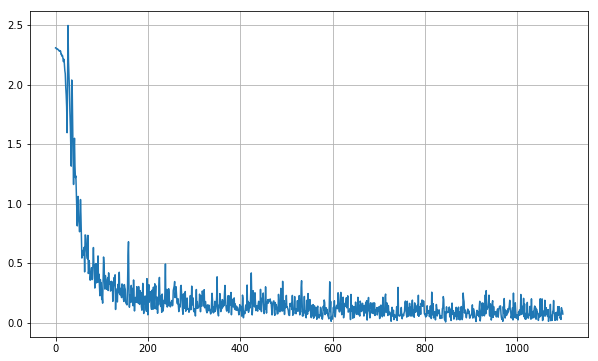

In [9]:
# plot losses
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(losses)
ax.grid(True)

In [10]:
# show evaluation accuracy
net.eval()
print get_accuracy(mnist.test.images,mnist.test.labels)

98.09%


prediction: 2 answer: 2
0 0.0%
1 0.0%
2 100.0%
3 0.0%
4 0.0%
5 0.0%
6 0.0%
7 0.0%
8 0.0%
9 0.0%


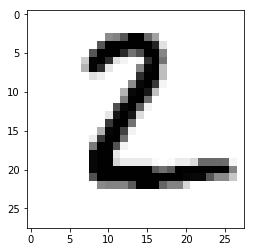

prediction: 6 answer: 6
0 0.06%
1 0.0%
2 0.0%
3 0.0%
4 0.0%
5 0.03%
6 99.91%
7 0.0%
8 0.0%
9 0.0%


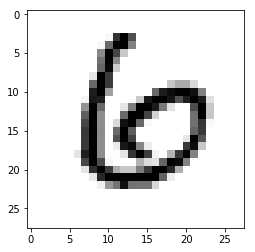

In [11]:
# test and show test images
test_idxs = [1,11]

net.eval()

for test_idx in test_idxs:
    test_x = Variable(torch.Tensor(mnist.test.images[test_idx]))
    test_y = mnist.test.labels[test_idx]

    _prediction = net(test_x)

    print 'prediction:', np.argmax(_prediction.data.numpy()), 'answer:', test_y

    for i,val in enumerate(_prediction[0]):
        print i, str(round(100*np.exp(val)/np.sum(np.exp(_prediction)),2))+'%'

    plt.imshow(test_x.data.numpy().reshape(28,28), cmap='binary')
    plt.show()